In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union

from sklearn import preprocessing
from sklearn import metrics

from sklearn.model_selection import cross_val_score, GridSearchCV,RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from mlxtend.classifier import StackingCVClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train_dataset.csv")#.dropna(subset=["language"]).reset_index()
test = pd.read_csv("test_dataset.csv")
labels = train.iloc[:,-1]
ids_test = test.id

# ZeroR and OneR

In [3]:
zeroR = [2] * test.shape[0]
largest_group = train.imdb_score_binned.value_counts().nlargest(n=1).values[0]
print(f"The ZeroR train accuracy is {largest_group/train.shape[0]}")

The ZeroR train accuracy is 0.6121837549933422


In [4]:
def OneR(df, col, labels):
    levels = {}

    if df.dtypes[col]=='int64':
        bins = np.histogram(df[col], bins=4)[1]
        values = pd.DataFrame({'var' :   pd.Series(np.digitize(df[col], bins)), 
                               'label' : labels})  

    else:
        if len(df[col].unique())<100:
            values = pd.DataFrame({'var' :  df[col], 'label' : labels})
        else:
            return [] # too computationally heavy if too many categories
    
    for x in values['var'].unique():
        class_ = values[values['var'] == x].label.value_counts().nlargest(1, keep='all')

        if len(class_)==0: 
            print(class_)
        
        if len(class_)>1: levels[x] = class_.sample(n=1)
        levels[x] = class_.index[0]

    pred = []
    for i in range(values.shape[0]):
        pred.append(levels[values['var'][i]])
    return(pred)

In [5]:
def OneR_fit(train, test, col):
    levels = {}
    
    # values is df with the binned values

    if train.dtypes[col]=='int64':
        bins = np.histogram(train[col], bins=4)[1]
        values = pd.DataFrame({'var' :   pd.Series(np.digitize(train[col], bins)), 
                               'label' : train['imdb_score_binned']})  

    else:
        if len(train[col].unique())<100:
            values = pd.DataFrame({'var' :  train[col], 'label' : train['imdb_score_binned']})
        else:
            return [] # too computationally heavy if too many categories
    
    for x in values['var'].unique():
        class_ = values[values['var'] == x].label.value_counts().nlargest(1, keep='all')
        
        if len(class_)>1: levels[x] = class_.sample(n=1)
        levels[x] = class_.index[0]

    # bin the test values
    test_values = pd.Series(np.digitize(test[col], bins))

    # Make predictions
    pred = []
    for i in range(len(test_values)):
        pred.append(levels[test_values[i]])
    return(pred)  

In [6]:
pred_list = {}
for i in range(1,train.shape[1]-1):
    col = train.columns[i]
    predictions = OneR(train, col, labels)
    pred_list[col] = predictions

In [7]:
scores = {}
for col in pred_list.keys():
    if len(pred_list[col])>0:
        accuracy = pd.DataFrame({'pred':pred_list[col], 'actual':labels})
        accuracy['correct'] = accuracy.actual==accuracy.pred
        score = sum(accuracy.correct)/len(accuracy.correct)
        scores[col] = score
top_score = max(scores, key=scores.get)

In [8]:
print(f"The OneR is {top_score} with train accuracy : {scores[top_score]}")

The OneR is num_voted_users with train accuracy : 0.6361517976031957


# Pre-processing

In [ ]:
def parse_average(arr: str) -> float:
    #output_array: List[float] = []
    arr = arr[1:-1]
    array: List[str] = arr.split()
    total: float = 0
    for i in range(len(array)):
        total = total + float(array[i])
    return total / len(array)

In [ ]:
def average_title_embedding(train_df: pd.DataFrame):
    print(len(train_df["title_embedding"]))
    av: pd.Series = train_df["title_embedding"].apply(parse_average)
    train_df["average_title_embedding"] = av  

In [11]:
# not used
def add_engineered_dir_features(df:pd.DataFrame):
    unique_dir = df["director_name"].unique()
    dir_movie_count: List[int] = [0] * len(df) #some random huge number. jut in case each director appears only once in the dataset

    nmovies_for_director: List[int] = [1] * len(df)
    dir_over_mean: List[int] = [0] * len(df)
    dir_over_std1: List[int] = [0] * len(df)

    for udir in unique_dir:
        count: int = 0
        for dir in df["director_name"]:
            if dir == udir:
                count+=1

        dir_movie_count[count] += 1

        if count > 1:
            for index, row in df[df["director_name"] == udir].iterrows():
                nmovies_for_director[index] = count

    nmovie_mean = np.mean(nmovies_for_director)
    nmovie_std1 = nmovie_mean + np.std(nmovies_for_director)

    for count in nmovies_for_director:
        #add it to a further array for 'well-known directors'
        if count >= nmovie_mean:
            dir_over_mean[index] = 1

        if count >= nmovie_mean + nmovie_std1:
            dir_over_std1[index] = 1

    df["nmovies_director"] = nmovies_for_director
    df["dir_over_mean"] = dir_over_mean
    df["dir_over_std1"] = dir_over_std1

In [12]:
# not used
def get_dir_avgross(df:pd.DataFrame):
    average_gross = ((df.groupby(["director_name"]))["gross"]).mean()

    avgross_dir:List[int] = [0] * len(df)

    for index, row in df.iterrows():
        avgross_dir[index] = average_gross[row["director_name"]]

    df["avgross_dir"] = avgross_dir

In [13]:
# not used
def sort_func(arr:List[List[Union[str,int]]]):
    return arr[1]

In [14]:
# not used
def n_top_countries(df:pd.DataFrame, n:int):
    unique_cnt = df["country"].unique()

    n_cnts: List[List[Union[str,int]]] = []

    for ucnt in unique_cnt:
        ucnt_arr = [ucnt, 0]
        for cnt in df["country"]:
            if cnt == ucnt:
                ucnt_arr[1]+=1

        n_cnts.append(ucnt_arr)


    cnt_sorted = sorted(n_cnts, key=sort_func)

    cnt_sorted = cnt_sorted[-n:]

    # now create columns for these top n countries
    for cnt in cnt_sorted:
        this_cnt:List[int] = []
        for row in df["country"]:
            if row == cnt[0]:
                this_cnt.append(1)
            else:
                this_cnt.append(0)
        df[cnt[0]] = this_cnt

In [15]:
# not used
def n_top_languages(df:pd.DataFrame, n:int):
    unique_lan = df["language"].unique()

    n_lans: List[List[Union[str,int]]] = []

    for ulan in unique_lan:
        ulan_arr = [ulan, 0]
        for lan in df["language"]:
            if lan == ulan:
                ulan_arr[1]+=1
        n_lans.append(ulan_arr)

    lan_sorted = sorted(n_lans, key=sort_func)

    lan_sorted = lan_sorted[-n:]

    # now create columns for these top n countries
    for lan in lan_sorted:
        this_lan:List[int] = []
        for row in df["language"]:
            if row == lan[0]:                
                this_lan.append(1)
            else:
                this_lan.append(0)
        df[lan[0]] = this_lan

In [ ]:
def preproc(df):
    # Fix the genre column

    genres = df['genres'].str.split("|")
    genres = list(set([a for b in genres.tolist() for a in b])) # get all the unique genres

    for x in genres:
        df[x] = df.genres.str.count(x) # this is gonna give 0 or 1 for each row and genre

    df.drop(["genres"], axis=1, inplace=True)

    # One hot encode language, country, content_rating
    df = pd.get_dummies(df, columns=["language", "country", "content_rating"], dtype=float)   
    df = df.select_dtypes(['number'])

    return(df)

In [16]:
train = train.iloc[:, :-1]
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

average_title_embedding(train)
average_title_embedding(test)

Data = preproc(train)
Test = preproc(test)

In [17]:
# ensure the one hot encoded columns are all the same and in the same order

train_cols = Data.columns
test_cols = Test.columns
missing_levels = train_cols.difference(test_cols)

for x in missing_levels:
    Test[x] = 0
Test = Test[Data.columns]

In [18]:
Data_copy = Data.copy() # Make a copy to recall the column names after scaling.

Data_scaler = preprocessing.MinMaxScaler() # create scaler
Data_scaler.fit(Data) #fit scaler
Data = Data_scaler.fit_transform(Data)
Data_df = pd.DataFrame(Data, columns = Data_copy.columns)

Test = Data_scaler.fit_transform(Test)
Test_df = pd.DataFrame(Test, columns = Data_copy.columns)

# Feature Selection

In [19]:
num_features = 50 # pick a number of feature importances and reasses later

model_rfi = RandomForestClassifier(n_estimators=100, random_state=11) #random forest for finding the important features
model_rfi.fit(Data, labels)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

In [20]:
best_features_rfi = Data_df.columns[fs_indices_rfi].values
best_features_rfi

array(['num_voted_users', 'num_user_for_reviews', 'duration',
       'title_year', 'gross', 'num_critic_for_reviews', 'avgross_dir',
       'actor_3_facebook_likes', 'movie_facebook_likes',
       'director_facebook_likes', 'actor_2_facebook_likes',
       'cast_total_facebook_likes', 'actor_1_facebook_likes',
       'average_degree_centrality', 'nmovies_director',
       'facenumber_in_poster', 'English', 'USA', 'UK', 'French',
       'Germany', 'Canada', 'France', 'Japanese', 'Spanish', 'German',
       'dir_over_mean', 'dir_over_std1'], dtype=object)

In [21]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([1.31260822e-01, 8.21817368e-02, 7.28069824e-02, 6.93645334e-02,
       6.67582731e-02, 6.34943579e-02, 6.13234442e-02, 5.80999185e-02,
       5.66732208e-02, 5.41960873e-02, 5.31342846e-02, 5.21424806e-02,
       4.49774015e-02, 4.41184680e-02, 2.78982447e-02, 2.35796194e-02,
       1.33571265e-02, 8.89129924e-03, 6.39255458e-03, 2.38587942e-03,
       1.96960080e-03, 1.69431231e-03, 1.66438563e-03, 6.67938042e-04,
       6.41046066e-04, 2.59534839e-04, 6.64472125e-05, 0.00000000e+00])

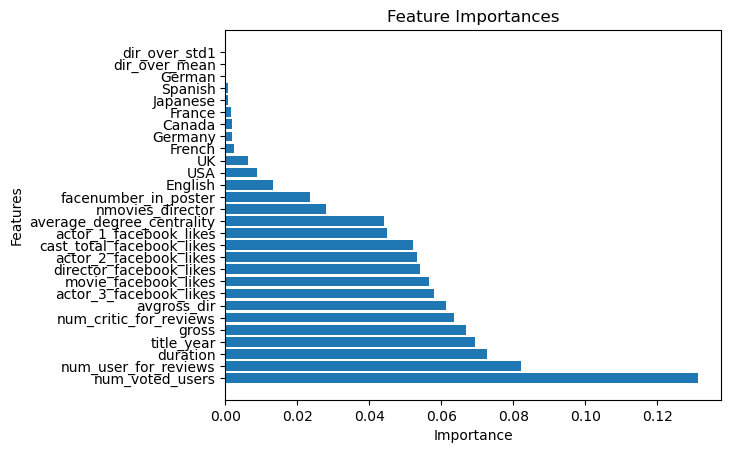

In [22]:
plt.barh(best_features_rfi, feature_importances_rfi)
plt.title('Feature Importances')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# below is how much of the variance each of the best 25 features can explain

In [23]:
D_train_fs20 = Data[:, fs_indices_rfi[0:20]]
D_test_fs20  = Test[:, fs_indices_rfi[0:20]]

D_train_fs50 = Data[:, fs_indices_rfi[0:50]]
D_test_fs50  = Test[:, fs_indices_rfi[0:50]]

D_train_fs = Data.copy()
D_test_fs  = Test.copy()

# Models

#### Define cross validation method, to be used throughout

In [24]:
cv_method = RepeatedStratifiedKFold(n_splits=5,
                                    n_repeats=3,
                                    random_state=11)

### KNN

### SVM

In [25]:
model_SVM_linear = SVC(kernel='linear', decision_function_shape='ovr', break_ties=True, probability=True)
print(np.mean(cross_val_score(model_SVM_linear, Data, labels, scoring='roc_auc_ovr', cv=cv_method, n_jobs=-1)))
print(np.mean(cross_val_score(model_SVM_linear, Data, labels, scoring='accuracy', cv=cv_method, n_jobs=-1)))

0.8309976886159478
0.6849761508596784


In [26]:
model_SVM_poly = SVC(kernel='poly', decision_function_shape='ovr', break_ties=True,probability=True)
np.mean(cross_val_score(model_SVM_poly, Data, labels, scoring='roc_auc_ovr', cv=cv_method, n_jobs=-1))

0.8170009982096237

In [27]:
model_SVM_sigmoid = SVC(kernel='sigmoid', decision_function_shape='ovr', break_ties=True,probability=True)
np.mean(cross_val_score(model_SVM_sigmoid, Data, labels, scoring='roc_auc_ovr', cv=cv_method, n_jobs=-1))

0.7388355178492971

In [28]:
# Predicting the train set results

model_SVM_linear.fit(Data, labels)
model_SVM_poly.fit(Data, labels)
model_SVM_sigmoid.fit(Data,labels)

linear_pred = model_SVM_linear.predict(Data)
poly_pred = model_SVM_poly.predict(Data)
sigmoid_pred = model_SVM_sigmoid.predict(Data)

linear_cm = metrics.confusion_matrix(labels, linear_pred)
poly_cm = metrics.confusion_matrix(labels, poly_pred)
sigmoid_cm = metrics.confusion_matrix(labels, sigmoid_pred)

In [29]:
print(f"SVM : Linear Kernel \n {linear_cm} \n") 
print(f"SVM : Polynomial Kernel \n {poly_cm} \n") 
print(f"SVM : Sigmoid Kernel \n {sigmoid_cm} \n") 
print("\n")

SVM : Linear Kernel 
 [[   0    0   24    0    0]
 [   0    0  233    2    0]
 [   0    0 1755   84    0]
 [   0    0  517  258    2]
 [   0    0    6   58   65]] 

SVM : Polynomial Kernel 
 [[   0    0   24    0    0]
 [   0    0  234    1    0]
 [   0    0 1767   72    0]
 [   0    0  493  282    2]
 [   0    0    3   60   66]] 

SVM : Sigmoid Kernel 
 [[   0    0   23    1    0]
 [   0    0  221   14    0]
 [   0    0 1610  229    0]
 [   0    2  549  226    0]
 [   0    1   46   74    8]] 





In [30]:
print("\nClassification report for Linear") 
print(metrics.classification_report(labels, linear_pred, zero_division=True))
print('---------------------------------------------------------')
print("\nClassification report for Polynomial") 
print(metrics.classification_report(labels, poly_pred,zero_division=True))
print('---------------------------------------------------------')
print("\nClassification report for Sigmoid") 
print(metrics.classification_report(labels, sigmoid_pred,zero_division=True))
print('---------------------------------------------------------')


Classification report for Linear
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        24
           1       1.00      0.00      0.00       235
           2       0.69      0.95      0.80      1839
           3       0.64      0.33      0.44       777
           4       0.97      0.50      0.66       129

    accuracy                           0.69      3004
   macro avg       0.86      0.36      0.38      3004
weighted avg       0.72      0.69      0.63      3004

---------------------------------------------------------

Classification report for Polynomial
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        24
           1       1.00      0.00      0.00       235
           2       0.70      0.96      0.81      1839
           3       0.68      0.36      0.47       777
           4       0.97      0.51      0.67       129

    accuracy                           0.70      3004
 

## SVM with Class Weight = Balanced 

In [31]:
SVM_linear_bal = SVC(kernel='linear', decision_function_shape='ovr', break_ties=True, probability=True, class_weight='balanced')
roc_lin = np.mean(cross_val_score(SVM_linear_bal, Data, labels, scoring='roc_auc_ovr', cv=cv_method, n_jobs=-1))
acc_lin = np.mean(cross_val_score(SVM_linear_bal, Data, labels, scoring='accuracy', cv=cv_method, n_jobs=-1))

In [32]:
SVM_poly_bal = SVC(kernel='poly', decision_function_shape='ovr', break_ties=True,probability=True, class_weight='balanced')
roc_poly = np.mean(cross_val_score(SVM_poly_bal, Data, labels, scoring='roc_auc_ovr', cv=cv_method, n_jobs=-1))
acc_poly = np.mean(cross_val_score(SVM_poly_bal, Data, labels, scoring='accuracy', cv=cv_method, n_jobs=-1))

In [33]:
SVM_sigmoid_bal = SVC(kernel='sigmoid', decision_function_shape='ovr', break_ties=True,probability=True, class_weight='balanced')
roc_sig = np.mean(cross_val_score(SVM_sigmoid_bal, Data, labels, scoring='roc_auc_ovr', cv=cv_method, n_jobs=-1))
acc_sig = np.mean(cross_val_score(SVM_sigmoid_bal, Data, labels, scoring='accuracy', cv=cv_method, n_jobs=-1))

In [34]:
# Predicting the train set results

SVM_linear_bal.fit(Data, labels)
SVM_poly_bal.fit(Data, labels)
SVM_sigmoid_bal.fit(Data,labels)

linear_pred_bal = SVM_linear_bal.predict(Data)
poly_pred_bal = SVM_poly_bal.predict(Data)
sigmoid_pred_bal = SVM_sigmoid_bal.predict(Data)

linear_cm_bal = metrics.confusion_matrix(labels, linear_pred_bal)
poly_cm_bal = metrics.confusion_matrix(labels, poly_pred_bal)
sigmoid_cm_bal = metrics.confusion_matrix(labels, sigmoid_pred_bal)

In [35]:
print(f"SVM : Linear Kernel \n {linear_cm_bal}")
print(f"roc_auc: {roc_lin} \naccuracy: {acc_lin}\n")
print(f"SVM : Polynomial Kernel \n {poly_cm_bal}")
print(f"roc_auc: {roc_poly} \naccuracy: {acc_poly}\n")
print(f"SVM : Sigmoid Kernel \n {sigmoid_cm_bal}") 
print(f"roc_auc: {roc_sig} \naccuracy: {acc_sig}")

SVM : Linear Kernel 
 [[ 22   1   1   0   0]
 [ 81 120  22  11   1]
 [344 508 650 310  27]
 [ 66  64 165 394  88]
 [  0   1   1   9 118]]
roc_auc: 0.8209151813633595 
accuracy: 0.41289166204474015

SVM : Polynomial Kernel 
 [[ 22   2   0   0   0]
 [ 78 122  23  12   0]
 [319 492 676 313  39]
 [ 60  62 140 424  91]
 [  0   0   1   8 120]]
roc_auc: 0.8221641485929543 
accuracy: 0.4213285265298576

SVM : Sigmoid Kernel 
 [[ 23   0   1   0   0]
 [141  52  31  10   1]
 [632 297 613 286  11]
 [127  38 231 312  69]
 [  8   0   8  27  86]]
roc_auc: 0.7847449486604895 
accuracy: 0.3432044740247735


### Random Forest

In [36]:
perf_metric = "roc_auc_ovr" 
criterion = ["gini", "entropy"]

In [37]:
# hyper parameters to search through

depth = np.linspace(1, 20, 20, endpoint=True).astype(int) # maximum depth of a tree
n_estimators = [100, 250, 500] # number of trees
params_RF = dict(criterion=criterion, max_depth=depth, n_estimators=n_estimators)

gs_RF = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=11, n_jobs=5), 
                           param_distributions=params_RF, 
                           cv=cv_method,
                           verbose=0,
                           n_iter=35,
                           scoring=perf_metric)

gs_RF.fit(D_train_fs, labels);

In [38]:
# hyper parameters to search through

depth = np.linspace(1, 20, 20, endpoint=True).astype(int) # maximum depth of a tree
n_estimators = [100, 250, 500] # number of trees
params_RF = dict(criterion=criterion, max_depth=depth, n_estimators=n_estimators)

gs_RF20 = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=11, n_jobs=5), 
                           param_distributions=params_RF, 
                           cv=cv_method,
                           verbose=0,
                           n_iter=35,
                           scoring=perf_metric)

gs_RF20.fit(D_train_fs20, labels);

In [39]:
# hyper parameters to search through

depth = np.linspace(1, 20, 20, endpoint=True).astype(int) # maximum depth of a tree
n_estimators = [100, 250, 500] # number of trees
params_RF = dict(criterion=criterion, max_depth=depth, n_estimators=n_estimators)

gs_RF50 = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=11, n_jobs=5), 
                           param_distributions=params_RF, 
                           cv=cv_method,
                           verbose=0,
                           n_iter=35,
                           scoring=perf_metric)

gs_RF50.fit(D_train_fs50, labels);

In [40]:
print(f"Best parameters: {gs_RF.best_params_}")
print(f"Best score: {gs_RF.best_score_}\n")

print(f"Best parameters (20 cols): {gs_RF20.best_params_}")
print(f"Best score (20 cols): {gs_RF20.best_score_}\n")

print(f"Best parameters (50 cols): {gs_RF50.best_params_}")
print(f"Best score (50 cols): {gs_RF50.best_score_}\n")

Best parameters: {'n_estimators': 500, 'max_depth': 18, 'criterion': 'gini'}
Best score: 0.8622740054249269

Best parameters (20 cols): {'n_estimators': 250, 'max_depth': 12, 'criterion': 'entropy'}
Best score (20 cols): 0.8628579486146151

Best parameters (50 cols): {'n_estimators': 500, 'max_depth': 14, 'criterion': 'gini'}
Best score (50 cols): 0.8652758962620521



In [41]:
pred_RF = gs_RF.predict(D_train_fs)
cm_RF = metrics.confusion_matrix(labels, pred_RF)

pred_RF20 = gs_RF20.predict(D_train_fs20)
cm_RF20 = metrics.confusion_matrix(labels, pred_RF20)

pred_RF50 = gs_RF50.predict(D_train_fs50)
cm_RF50 = metrics.confusion_matrix(labels, pred_RF50)

In [42]:
print(f"Confusion Matrix: All columns \n{cm_RF}\n")
print(f"Confusion Matrix: Top 20 columns \n{cm_RF20}\n")
print(f"Confusion Matrix: Top 50 columns \n{cm_RF50}\n")

Confusion Matrix: All columns 
[[  21    0    3    0    0]
 [   0  227    8    0    0]
 [   0    0 1839    0    0]
 [   0    0    2  775    0]
 [   0    0    0    0  129]]

Confusion Matrix: Top 20 columns 
[[  12    0   12    0    0]
 [   0  112  123    0    0]
 [   0    0 1839    0    0]
 [   0    0   62  715    0]
 [   0    0    0    0  129]]

Confusion Matrix: Top 50 columns 
[[   9    0   15    0    0]
 [   0  115  120    0    0]
 [   0    0 1839    0    0]
 [   0    0   56  721    0]
 [   0    0    1    0  128]]



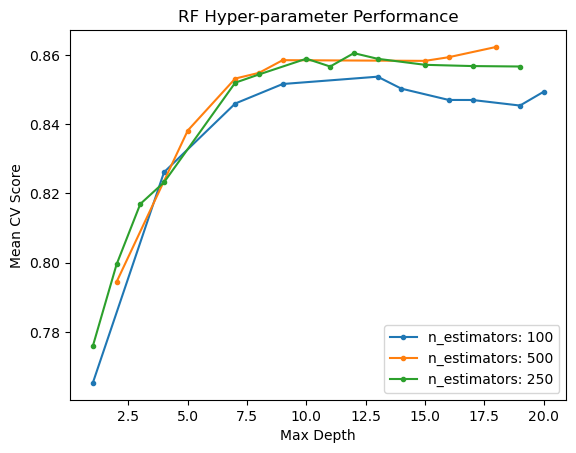

In [43]:
results_RF = pd.DataFrame(gs_RF.cv_results_['params'])
results_RF['test_score'] = gs_RF.cv_results_['mean_test_score']

for i in results_RF['n_estimators'].unique():
    perf = results_RF[results_RF['n_estimators'] == i]
    perf_average = perf.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(perf_average, marker = '.', label = 'n_estimators: ' + str(i))
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("RF Hyper-parameter Performance")
plt.show()

### AdaBoost

In [62]:
params_Ada = dict(algorithm=["SAMME", "SAMME.R"], n_estimators=[100, 250, 500])

# set Decision Tree max depth to 1, to make it a decision stump.
# previously AdaBoost was overfitting when using a Decision Tree with no maximum depth. 
gs_Ada = GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), random_state=11),
                      param_grid=params_Ada,
                      cv=cv_method,
                      verbose=0,
                      scoring=perf_metric)

gs_Ada.fit(D_train_fs, labels);

In [61]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(D_train_fs, labels)
pred_stump = stump.predict(D_train_fs)
cm_stump = metrics.confusion_matrix(labels, pred_stump)
print(cm_stump)

[[   0    0   24    0    0]
 [   0    0  232    3    0]
 [   0    0 1705  134    0]
 [   0    0  537  240    0]
 [   0    0   24  105    0]]


Best parameters: {'algorithm': 'SAMME', 'n_estimators': 100}
Best score: 0.7907178809913439

In [63]:
print(f"Best parameters: {gs_Ada.best_params_}")
print(f"Best score: {gs_Ada.best_score_}")

Best parameters: {'algorithm': 'SAMME', 'n_estimators': 100}
Best score: 0.8187565043479018


In [64]:
pred_Ada = gs_Ada.predict(D_train_fs)
cm_Ada = metrics.confusion_matrix(labels, pred_Ada)
print(cm_Ada)

[[   4    4   16    0    0]
 [   0   78  148    9    0]
 [   1  123 1337  378    0]
 [   0    5  217  541   14]
 [   0    0    1   44   84]]


### Stacking Ensemble

In [44]:
models = dict()

models['KNN'] = KNeighborsClassifier()
models['SVM'] = SVC(kernel='linear', decision_function_shape='ovr', break_ties=True, class_weight='balanced', probability=True, random_state=11)
models['LR'] = LogisticRegression(max_iter=1000, solver='sag', random_state=11)
models['MNB'] = MultinomialNB()
models['DT'] = DecisionTreeClassifier(random_state=11)
models['RF'] = RandomForestClassifier(random_state=11)
models['ADABOOST'] = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,random_state=11),random_state=11)

In [45]:
for model in models:
    scores = cross_val_score(models[model], Data, labels, scoring='accuracy', cv=cv_method, n_jobs=-1, error_score='raise')
    print(model)
    print(scores)

KNN
[0.60898502 0.61231281 0.62562396 0.64559068 0.635      0.63560732
 0.6655574  0.6422629  0.62728785 0.62166667 0.64559068 0.63061564
 0.62562396 0.65890183 0.63833333]
SVM
[0.4093178  0.4359401  0.36605657 0.45257903 0.40666667 0.41264559
 0.42429285 0.40432612 0.41930116 0.41166667 0.4109817  0.36772047
 0.43261231 0.43926789 0.4       ]
LR
[0.6672213  0.68219634 0.6672213  0.67221298 0.675      0.6655574
 0.71214642 0.65391015 0.65890183 0.66666667 0.68053245 0.65224626
 0.67387687 0.69550749 0.66166667]
MNB
[0.62895175 0.62063228 0.62562396 0.62396007 0.64       0.63560732
 0.63394343 0.62396007 0.60732113 0.62333333 0.62229617 0.62063228
 0.63560732 0.62895175 0.62666667]
DT
[0.59900166 0.61896839 0.60232945 0.59234609 0.595      0.64392679
 0.60232945 0.63394343 0.62895175 0.59833333 0.61730449 0.56572379
 0.59400998 0.6422629  0.63166667]
RF
[0.73377704 0.72379368 0.6921797  0.72878536 0.72166667 0.72046589
 0.75207987 0.73377704 0.70049917 0.69666667 0.72379368 0.69384359
 

In [46]:
predictions = []
for model in models:
    models[model].fit(Data,labels)
    model_pred = models[model].predict(Data)
    predictions.append(pd.Series(model_pred)) 
pred_all = pd.concat([predictions[0],predictions[1],predictions[2],predictions[3],
                      predictions[4],predictions[5],predictions[6]], axis=1)
pred_all.columns = models.keys()
pred_all.corr()

,KNN,SVM,LR,MNB,DT,RF,ADABOOST
KNN,1.000000,0.560940,0.580909,0.335018,0.569633,0.569633,0.403688
SVM,0.560940,1.000000,0.610960,0.301653,0.543770,0.543770,0.534145
LR,0.580909,0.610960,1.000000,0.466282,0.529054,0.529054,0.494961
MNB,0.335018,0.301653,0.466282,1.000000,0.264889,0.264889,0.257591
DT,0.569633,0.543770,0.529054,0.264889,1.000000,1.000000,0.432365
RF,0.569633,0.543770,0.529054,0.264889,1.000000,1.000000,0.432365
ADABOOST,0.403688,0.534145,0.494961,0.257591,0.432365,0.432365,1.000000


In [47]:
# Remove SVM, Logistic Regression, and Decision Tree
# since these had higher correlations with other models.

pred_all.drop(["LR", "SVM", "DT"], axis=1).corr()

,KNN,MNB,RF,ADABOOST
KNN,1.000000,0.335018,0.569633,0.403688
MNB,0.335018,1.000000,0.264889,0.257591
RF,0.569633,0.264889,1.000000,0.432365
ADABOOST,0.403688,0.257591,0.432365,1.000000


In [48]:
base = list()
base.append(models['KNN'])
base.append(models['MNB'])
base.append(models['RF'])
base.append(models['ADABOOST'])

 # define meta learner model
meta = LogisticRegression(max_iter=1500, multi_class="multinomial", solver='sag',penalty='l2',random_state=11)

# define the stacking ensemble
stack_model = StackingCVClassifier(classifiers=base, meta_classifier=meta, cv=5, stratify=False, random_state=11, use_probas=True)

In [49]:
stack_model.fit(Data, labels)
stack_pred = stack_model.predict(Data)
stack_cm = metrics.confusion_matrix(labels, stack_pred)
print(f"Confusion matrix: Stack \n{stack_cm}")
print(f"Accuracy: {stack_model.score(Data, labels)}")

Confusion matrix: Stack 
[[   0    1   23    0    0]
 [   0  235    0    0    0]
 [   0    0 1839    0    0]
 [   0    0    0  777    0]
 [   0    0    0    0  129]]
Accuracy: 0.9920106524633822


In [50]:
# kaggle = pd.DataFrame({'id': ids_test, 'imdb_score_binned':stack_model.predict(Test)})
# kaggle.to_csv("results_stack_engineered_feature.csv", index=False)

In [82]:
# kaggle = pd.DataFrame({'id': ids_test, 'imdb_score_binned': stack_model.predict(Test)})
# kaggle.to_csv("results_stack99.csv", index=False)

In [ ]:
# pd.set_option('display.max_columns', None)

# Data.head()